In [1]:
# Cell 1: Setup, Imports, and Helper Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import os
import sys

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Add the project root to the Python path to allow imports from src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import config
import pandas_datareader.data as web

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported and configuration loaded.")


def get_risk_free_rate(start_date, end_date):
    """Fetches the 3-Month Treasury Bill Rate from FRED as the risk-free rate."""
    try:
        rf = web.DataReader('DTB3', 'fred', start_date, end_date)
        rf = rf.ffill() / 100 / 360
        return rf
    except Exception as e:
        return pd.Series(0, index=pd.date_range(start=start_date, end=end_date), name='DTB3')

/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries imported and configuration loaded.


In [3]:
# Cell 2: (Part 1) Load and Prepare Data

print("--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS ---")
print("\nLoading data...")

try:
    features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Original 3-factor dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# Prepare data for regression
full_df_orig = index_df.join(features_df, how='inner')
full_df_orig['pca_return'] = np.log(full_df_orig['Value']).diff()
rf_rate = get_risk_free_rate(full_df_orig.index.min(), full_df_orig.index.max())
full_df_orig['rf_rate'] = rf_rate['DTB3'].reindex(full_df_orig.index, method='ffill').fillna(0)
full_df_orig['pca_excess_return'] = full_df_orig['pca_return'] - full_df_orig['rf_rate']
full_df_orig.dropna(inplace=True)

# Define X, y and the CV strategy
X_orig = full_df_orig[['MKT', 'SMB', 'WML']]
y_orig = full_df_orig['pca_excess_return']
tscv = TimeSeriesSplit(n_splits=5)

# Scale features for relevant models
scaler_orig = StandardScaler()
X_orig_scaled = scaler_orig.fit_transform(X_orig)

print("Data for Part 1 is prepared.")

--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS ---

Loading data...
Original 3-factor dataset loaded successfully.
Data for Part 1 is prepared.


In [5]:
# Cell 3: (Part 1) Train All Models

print("Training all 5 models on the original 3-factor dataset...")

# 1. Statsmodels OLS (for p-values)
X_sm_orig = sm.add_constant(X_orig)
sm_results_orig = sm.OLS(y_orig, X_sm_orig).fit()

# 2. RidgeCV
ridge_cv_orig = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=tscv).fit(X_orig_scaled, y_orig)

# 3. LassoCV
lasso_cv_orig = LassoCV(alphas=np.logspace(-6, 2, 100), cv=tscv, random_state=42).fit(X_orig_scaled, y_orig)

# 4. Random Forest
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf_grid_orig = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_orig, y_orig)
best_rf_orig = rf_grid_orig.best_estimator_

# 5. XGBoost
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
xgb_grid_orig = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_orig, y_orig)
best_xgb_orig = xgb_grid_orig.best_estimator_

print("All models for Part 1 have been trained.")

Training all 5 models on the original 3-factor dataset...
All models for Part 1 have been trained.


In [10]:
# Cell 4: (Part 1) Display Results

print("--- RESULTS FOR ORIGINAL 3-FACTOR MODELS ---")

# --- 1. Coefficients for Linear Models ---
# Note: OLS coeffs are from unscaled data for direct interpretation.
# Ridge/Lasso coeffs are from scaled data, showing shrinkage.
coeffs_df = pd.DataFrame({
    'OLS Coefficient': sm_results_orig.params,
    'P-Value': sm_results_orig.pvalues
}).rename(index={'const': 'Intercept'})

# Add scaled coefficients for Ridge and Lasso
coeffs_df['Ridge Coefficient (Scaled)'] = pd.Series(ridge_cv_orig.coef_, index=X_orig.columns)
coeffs_df['Lasso Coefficient (Scaled)'] = pd.Series(lasso_cv_orig.coef_, index=X_orig.columns)
coeffs_df.fillna('-', inplace=True)

print("\n--- Linear Model Coefficients & P-Values ---")
display(coeffs_df)


# --- 2. Feature Importances for Tree-Based Models ---
# For these models, "importance" is the equivalent of a coefficient's magnitude.
importances_df = pd.DataFrame({
    'Random Forest Importance': best_rf_orig.feature_importances_,
    'XGBoost Importance': best_xgb_orig.feature_importances_
}, index=X_orig.columns).sort_values(by='XGBoost Importance', ascending=False)

print("\n--- Tree-Based Model Feature Importances ---")
display(importances_df)


# --- 3. Model Performance Comparison ---
results_data = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_orig.rsquared_adj,
        r2_score(y_orig, ridge_cv_orig.predict(X_orig_scaled)),
        r2_score(y_orig, lasso_cv_orig.predict(X_orig_scaled)),
        rf_grid_orig.best_score_,
        xgb_grid_orig.best_score_
    ]
}
results_df_orig = pd.DataFrame(results_data)
print("\n--- Overall Model Performance on 3 Factors ---")
display(results_df_orig)

--- RESULTS FOR ORIGINAL 3-FACTOR MODELS ---

--- Linear Model Coefficients & P-Values ---


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_96652/1673563601.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coeffs_df.fillna('-', inplace=True)


,OLS Coefficient,P-Value,Ridge Coefficient (Scaled),Lasso Coefficient (Scaled)
Intercept,0.001734,4.709269e-02,-,-
MKT,0.699650,8.480660e-68,0.022506,0.021646
SMB,-0.005889,8.639482e-01,-0.000252,-0.0
WML,0.009064,8.285087e-01,0.000611,0.0



--- Tree-Based Model Feature Importances ---


,Random Forest Importance,XGBoost Importance
MKT,0.907686,0.852602
WML,0.055285,0.086540
SMB,0.037029,0.060859



--- Overall Model Performance on 3 Factors ---


,Model,Out-of-Sample R-squared
0,OLS,0.738155
1,Ridge,0.740393
2,Lasso,0.736818
3,Random Forest,0.613215
4,XGBoost,0.544672


In [7]:
# Cell 5: (Part 2) Load and Prepare Data

print("\n\n--- PART 2: ANALYSIS WITH ENGINEERED FEATURES ---")
print("\nLoading data...")

try:
    features_df_eng = pd.read_csv(config.PROCESSED_DATA_DIR / 'engineered_features.csv', index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Engineered features dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run feature_engineering.py first. Missing: {e.filename}")

# Prepare data for regression
full_df_eng = index_df.join(features_df_eng, how='inner')
full_df_eng['pca_return'] = np.log(full_df_eng['Value']).diff()
rf_rate = get_risk_free_rate(full_df_eng.index.min(), full_df_eng.index.max())
full_df_eng['rf_rate'] = rf_rate['DTB3'].reindex(full_df_eng.index, method='ffill').fillna(0)
full_df_eng['pca_excess_return'] = full_df_eng['pca_return'] - full_df_eng['rf_rate']
full_df_eng.dropna(inplace=True)

# Define X and y with engineered features
X_eng = full_df_eng.drop(columns=['Value', 'pca_return', 'rf_rate', 'pca_excess_return'])
y_eng = full_df_eng['pca_excess_return']
scaler_eng = StandardScaler()
X_eng_scaled = scaler_eng.fit_transform(X_eng)

print("Data for Part 2 is prepared.")



--- PART 2: ANALYSIS WITH ENGINEERED FEATURES ---

Loading data...
Engineered features dataset loaded successfully.
Data for Part 2 is prepared.


In [8]:
# Cell 6: (Part 2) Train All Models

print("Training all 5 models on the engineered feature dataset...")
# (Using the same models and grids, but with the new X_eng and y_eng data)

# 1. Statsmodels OLS
X_sm_eng = sm.add_constant(X_eng)
sm_results_eng = sm.OLS(y_eng, X_sm_eng).fit()

# 2. RidgeCV
ridge_cv_eng = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=tscv).fit(X_eng_scaled, y_eng)

# 3. LassoCV
lasso_cv_eng = LassoCV(alphas=np.logspace(-6, 2, 100), cv=tscv, random_state=42).fit(X_eng_scaled, y_eng)

# 4. Random Forest
# Using the same grid search setup
rf_grid_eng = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_eng, y_eng)
best_rf_eng = rf_grid_eng.best_estimator_

# 5. XGBoost
# Using the same grid search setup
xgb_grid_eng = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_eng, y_eng)
best_xgb_eng = xgb_grid_eng.best_estimator_

print("All models for Part 2 have been trained.")

Training all 5 models on the engineered feature dataset...
All models for Part 2 have been trained.


--- RESULTS FOR ENGINEERED FEATURE MODELS ---

--- Model Performance on Engineered Features ---


,Model,Out-of-Sample R-squared
0,OLS,0.735528
1,Ridge,0.743995
2,Lasso,0.734962
3,Random Forest,0.603221
4,XGBoost,0.575352



--- Feature Importance from Best Performing Model (XGBoost) ---
Top 15 Most Important Features:


MKT                 0.244220
SMB_roll_std_30D    0.058057
MKT_lag_3           0.045694
WML_roll_std_7D     0.042174
SMB_roll_avg_7D     0.041024
WML_roll_avg_30D    0.035953
SMB_lag_1           0.032717
SMB_roll_avg_30D    0.030381
WML_roll_avg_7D     0.029547
WML_roll_std_30D    0.029397
MKT_lag_1           0.028654
MKT_roll_std_7D     0.028165
WML_lag_3           0.026534
WML_lag_4           0.025645
SMB_lag_2           0.024131
dtype: float32

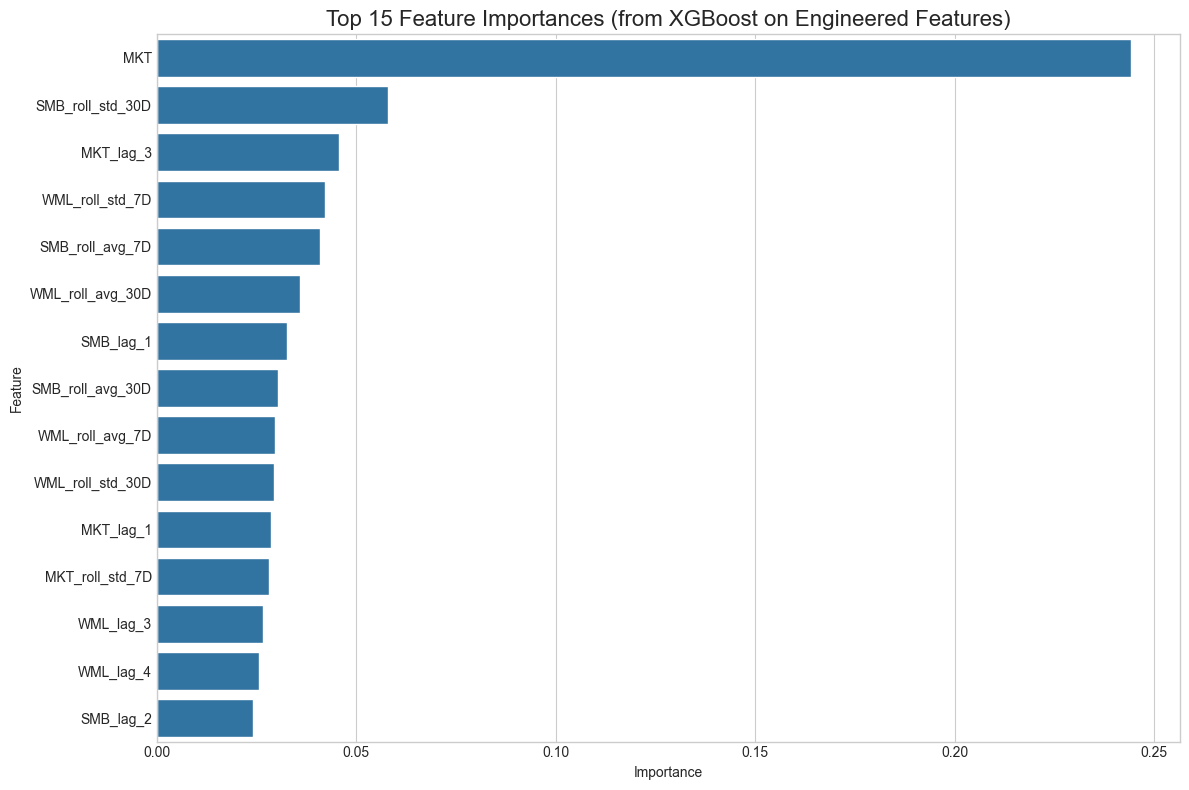

In [9]:
# Cell 7: (Part 2) Display Results and Feature Importance

print("--- RESULTS FOR ENGINEERED FEATURE MODELS ---")

# --- Model Performance Comparison ---
results_data_eng = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_eng.rsquared_adj,
        r2_score(y_eng, ridge_cv_eng.predict(X_eng_scaled)),
        r2_score(y_eng, lasso_cv_eng.predict(X_eng_scaled)),
        rf_grid_eng.best_score_,
        xgb_grid_eng.best_score_
    ]
}
results_df_eng = pd.DataFrame(results_data_eng)
print("\n--- Model Performance on Engineered Features ---")
display(results_df_eng)

# --- Feature Importance Analysis ---
print("\n--- Feature Importance from Best Performing Model (XGBoost) ---")
feature_importances = pd.Series(best_xgb_eng.feature_importances_, index=X_eng.columns).sort_values(ascending=False)

# Display & Plot Top 15 Features
print("Top 15 Most Important Features:")
display(feature_importances.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.head(15).values, y=feature_importances.head(15).index)
plt.title('Top 15 Feature Importances (from XGBoost on Engineered Features)', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [11]:
# Cell 8: (Part 2) Display Results

print("--- RESULTS FOR ENGINEERED FEATURE MODELS ---")

# --- 1. Coefficients for Linear Models ---
# Note: This will be a much larger table
coeffs_df_eng = pd.DataFrame({
    'OLS Coefficient': sm_results_eng.params,
    'P-Value': sm_results_eng.pvalues
}).rename(index={'const': 'Intercept'})

# Add scaled coefficients for Ridge and Lasso
coeffs_df_eng['Ridge Coefficient (Scaled)'] = pd.Series(ridge_cv_eng.coef_, index=X_eng.columns)
coeffs_df_eng['Lasso Coefficient (Scaled)'] = pd.Series(lasso_cv_eng.coef_, index=X_eng.columns)
coeffs_df_eng.fillna('-', inplace=True)

print("\n--- Linear Model Coefficients & P-Values (Top 10 by OLS Coeff Magnitude) ---")
# Display top 10 most influential features according to OLS
top_10_ols = coeffs_df_eng.reindex(coeffs_df_eng['OLS Coefficient'].abs().sort_values(ascending=False).index).head(11)
display(top_10_ols)
print("Note: Lasso may have set many of these coefficients to zero, indicating feature selection.")


# --- 2. Feature Importances for Tree-Based Models ---
importances_df_eng = pd.DataFrame({
    'Random Forest Importance': best_rf_eng.feature_importances_,
    'XGBoost Importance': best_xgb_eng.feature_importances_
}, index=X_eng.columns).sort_values(by='XGBoost Importance', ascending=False)

print("\n--- Tree-Based Model Feature Importances (Top 15) ---")
display(importances_df_eng.head(15))

# --- 3. Model Performance Comparison ---
results_data_eng = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_eng.rsquared_adj,
        r2_score(y_eng, ridge_cv_eng.predict(X_eng_scaled)),
        r2_score(y_eng, lasso_cv_eng.predict(X_eng_scaled)),
        rf_grid_eng.best_score_,
        xgb_grid_eng.best_score_
    ]
}
results_df_eng = pd.DataFrame(results_data_eng)
print("\n--- Overall Model Performance on Engineered Features ---")
display(results_df_eng)

--- RESULTS FOR ENGINEERED FEATURE MODELS ---

--- Linear Model Coefficients & P-Values (Top 10 by OLS Coeff Magnitude) ---


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_96652/1266678734.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coeffs_df_eng.fillna('-', inplace=True)


,OLS Coefficient,P-Value,Ridge Coefficient (Scaled),Lasso Coefficient (Scaled)
WML_roll_avg_30D,0.747190,1.008787e-01,0.001127,0.0
MKT,0.716907,7.729564e-41,0.018497,0.021632
MKT_roll_avg_30D,-0.511502,8.873644e-02,-0.00093,0.0
SMB_roll_avg_7D,-0.355890,2.223056e-01,-0.001307,-0.0
WML_roll_std_7D,-0.315234,9.704901e-02,-0.00094,-0.0
SMB_roll_avg_30D,0.211461,3.789729e-01,0.000786,0.0
MKT_roll_std_7D,0.186708,1.360852e-01,0.000847,0.0
MKT_roll_std_30D,-0.119151,7.207042e-01,-0.000249,-0.0
WML_roll_std_30D,0.103962,6.999439e-01,-0.000345,-0.0
SMB_roll_std_30D,-0.092340,7.754201e-01,-0.000884,-0.0


Note: Lasso may have set many of these coefficients to zero, indicating feature selection.

--- Tree-Based Model Feature Importances (Top 15) ---


,Random Forest Importance,XGBoost Importance
MKT,0.825110,0.244220
SMB_roll_std_30D,0.005831,0.058057
MKT_lag_3,0.002354,0.045694
WML_roll_std_7D,0.007204,0.042174
SMB_roll_avg_7D,0.006261,0.041024
WML_roll_avg_30D,0.002577,0.035953
SMB_lag_1,0.013504,0.032717
SMB_roll_avg_30D,0.003297,0.030381
WML_roll_avg_7D,0.005348,0.029547
WML_roll_std_30D,0.003451,0.029397



--- Overall Model Performance on Engineered Features ---


,Model,Out-of-Sample R-squared
0,OLS,0.735528
1,Ridge,0.743995
2,Lasso,0.734962
3,Random Forest,0.603221
4,XGBoost,0.575352


In [12]:
# Cell 8: (Part 3) Prepare Data for ARIMAX

print("\n\n--- PART 3: TIME-SERIES FORECASTING WITH ARIMAX ---")
print("\nLoading data for ARIMAX model...")

try:
    features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# Join the datasets to align them perfectly
arimax_df = index_df.join(features_df, how='inner')
arimax_df.dropna(inplace=True)

# Define our endogenous (target) variable 'y' and exogenous (external) factors 'X'
# For ARIMAX, we predict the actual index VALUE, not the returns.
y_arimax = arimax_df['Value']
X_arimax = arimax_df[['MKT', 'SMB', 'WML']]

# We must add a constant to the exogenous variables for the model to estimate an intercept
X_arimax_const = sm.add_constant(X_arimax)

print("Data for ARIMAX prepared.")
display(arimax_df.head())



--- PART 3: TIME-SERIES FORECASTING WITH ARIMAX ---

Loading data for ARIMAX model...
Data loaded successfully.
Data for ARIMAX prepared.


,Value,MKT,SMB,WML
Date,,,,
2024-08-31,777.287043,-0.005093,-0.007866,-0.009154
2024-09-01,774.152081,-0.011407,0.006754,-0.009431
2024-09-02,751.216942,-0.034723,0.013046,-0.019612
2024-09-03,777.939308,0.033861,-0.020780,0.024564
2024-09-04,754.473197,-0.038033,0.002201,-0.020761


ADF Statistic: -1.9340
p-value: 0.3162
Conclusion: The series is non-stationary (d=1 is likely needed).


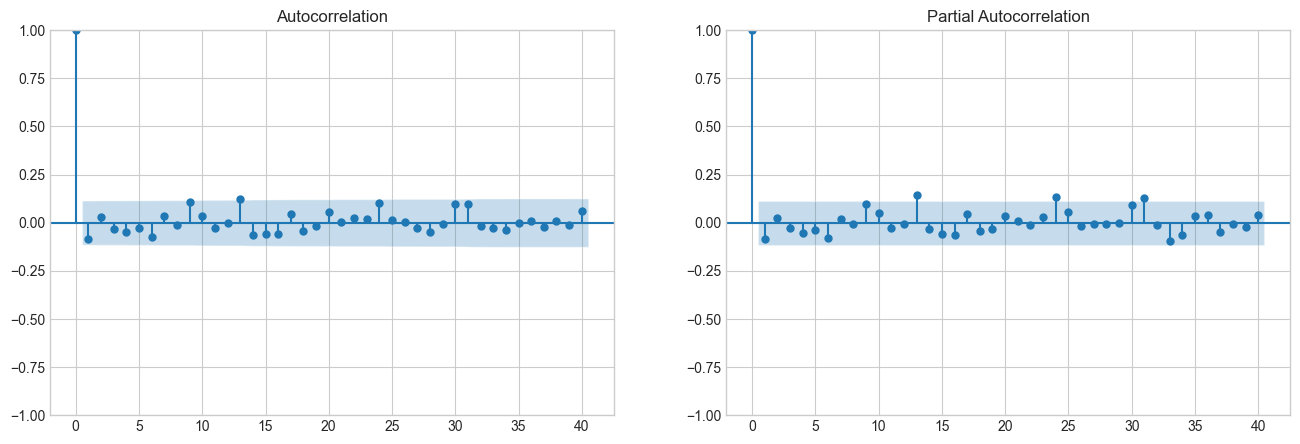

In [13]:
# Cell 9: (Part 3) Stationarity Check and Order Selection (p, d, q)
# Key imports for ARIMA analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# 1. Check stationarity of the target variable to determine 'd'
def check_stationarity(timeseries):
    """Performs the Augmented Dickey-Fuller test."""
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: The series is stationary (d=0).")
        return True, 0
    else:
        print("Conclusion: The series is non-stationary (d=1 is likely needed).")
        return False, 1

is_stationary, d_value = check_stationarity(y_arimax)
data_for_plots = y_arimax.diff().dropna() if not is_stationary else y_arimax

# 2. Plot ACF and PACF to determine 'p' and 'q'
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_for_plots, ax=axes[0], lags=40)
plot_pacf(data_for_plots, ax=axes[1], lags=40)
plt.show()

In [14]:
# Cell 10: (Part 3) Fit the ARIMAX Model

# Define the order based on the previous cell's analysis
p, d, q = 1, 1, 1

print(f"Fitting ARIMAX(p={p}, d={d}, q={q}) model with exogenous factors...")

# Instantiate and fit the model, passing the factors to the `exog` parameter
# The model internally handles the differencing for both the endogenous and exogenous variables.
arimax_model = ARIMA(endog=y_arimax, exog=X_arimax_const, order=(p, d, q))
arimax_fitted = arimax_model.fit()

# Print the model summary
print(arimax_fitted.summary())

Fitting ARIMAX(p=1, d=1, q=1) model with exogenous factors...


/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  295
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1310.988
Date:                Mon, 30 Jun 2025   AIC                           2635.975
Time:                        03:32:14   BIC                           2661.760
Sample:                    08-31-2024   HQIC                          2646.301
                         - 06-21-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018   2.83e-05    -62.225      0.000      -0.002      -0.002
MKT          383.7626     28.363     13.530      0.000     328.172     439.353
SMB          -38.0219     26.826     -1.417      0.1

--- Future Factor Scenario ---


,const,MKT,SMB,WML
2025-06-22,1.0,-0.030722,-0.007814,0.001224
2025-06-23,1.0,-0.030722,-0.007814,0.001224
2025-06-24,1.0,-0.030722,-0.007814,0.001224
2025-06-25,1.0,-0.030722,-0.007814,0.001224
2025-06-26,1.0,-0.030722,-0.007814,0.001224



Generating forecast...


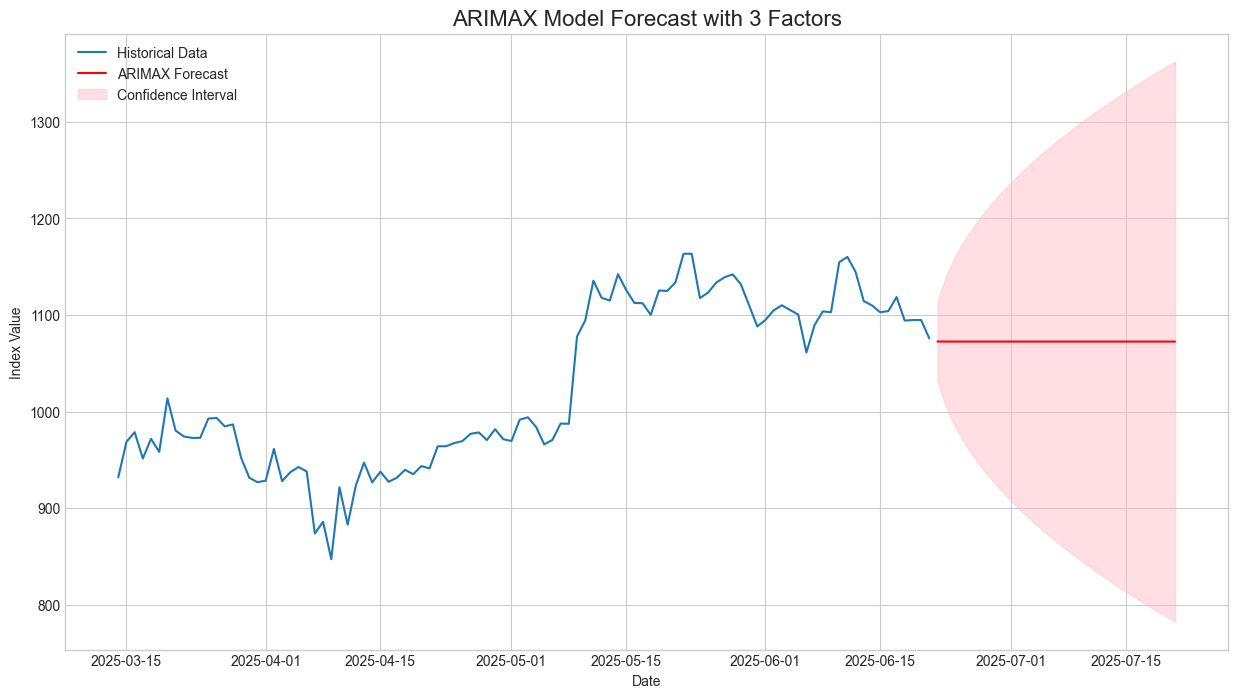

In [15]:
# Cell 11: (Part 3) Forecasting with an ARIMAX Model

# --- Create future scenarios for the exogenous variables ---
n_forecast = 30 # Number of days to forecast
last_date = X_arimax_const.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast)

# Scenario 1: Assume factors hold their last value
last_known_factors = X_arimax_const.iloc[-1]
future_factors = pd.DataFrame([last_known_factors.values]*n_forecast, 
                              index=future_dates, 
                              columns=X_arimax_const.columns)

print("--- Future Factor Scenario ---")
display(future_factors.head())


# --- Generate the forecast ---
print("\nGenerating forecast...")
forecast = arimax_fitted.get_forecast(steps=n_forecast, exog=future_factors)

# Get forecast values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- Plot the results ---
plt.figure(figsize=(15, 8))
# Plot historical data (last 100 days for context)
plt.plot(y_arimax.tail(100), label='Historical Data')

# Plot the forecast
plt.plot(forecast_mean, label='ARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='Confidence Interval')

plt.title('ARIMAX Model Forecast with 3 Factors', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.show()

In [16]:
# Cell 12: (New) Introduction and Data Split for Out-of-Sample Testing

print("\n\n--- PART 4: OUT-OF-SAMPLE VALIDATION WITH TRAIN-TEST SPLIT ---")
print("\nHere, we will hold out the last 30 days of data to test the model's real-world forecasting performance.")

# We will use the 'arimax_df' DataFrame created in Cell 8
# If you are running this cell independently, uncomment the lines below to load data
# index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
# features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
# arimax_df = index_df.join(features_df, how='inner').dropna()
# y_arimax = arimax_df['Value']
# X_arimax_const = sm.add_constant(arimax_df[['MKT', 'SMB', 'HML']])


# --- Create the Train-Test Split ---
# We will train on all data before May 20, 2025, and test on the data after.
split_date = '2025-05-20'
print(f"\nSplitting data into training and testing sets at {split_date}...")

y_train = y_arimax[y_arimax.index <= split_date]
y_test = y_arimax[y_arimax.index > split_date]

X_train = X_arimax_const[X_arimax_const.index <= split_date]
X_test = X_arimax_const[X_arimax_const.index > split_date]

n_test = len(y_test)
print(f"Training set size: {len(y_train)} observations")
print(f"Testing set size:  {n_test} observations")



--- PART 4: OUT-OF-SAMPLE VALIDATION WITH TRAIN-TEST SPLIT ---

Here, we will hold out the last 30 days of data to test the model's real-world forecasting performance.

Splitting data into training and testing sets at 2025-05-20...
Training set size: 263 observations
Testing set size:  32 observations


In [17]:
# Cell 13: (New) Re-Fit the ARIMAX Model on Training Data Only

# The p,d,q order should be determined from the training data's ACF/PACF plots.
# We will proceed with the (1, 1, 1) order we found earlier.
p, d, q = 1, 1, 1

print(f"Fitting ARIMAX(p={p}, d={d}, q={q}) model on the TRAINING data only...")

# Instantiate and fit a new model instance on the training sets
arimax_model_train = ARIMA(endog=y_train, exog=X_train, order=(p, d, q))
arimax_fitted_train = arimax_model_train.fit()

# Print the model summary. Note that this is for the model fitted only on past data.
print(arimax_fitted_train.summary())

Fitting ARIMAX(p=1, d=1, q=1) model on the TRAINING data only...
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1176.729
Date:                Mon, 30 Jun 2025   AIC                           2367.458
Time:                        03:42:24   BIC                           2392.436
Sample:                    08-31-2024   HQIC                          2377.497
                         - 05-20-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021   9.33e+05  -2.23e-09      1.000   -1.83e+06    1.83e+06
MKT          381.7219     30.962     12.329      0.000     321.037

/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


--- Generating Out-of-Sample Forecast for the Test Period ---


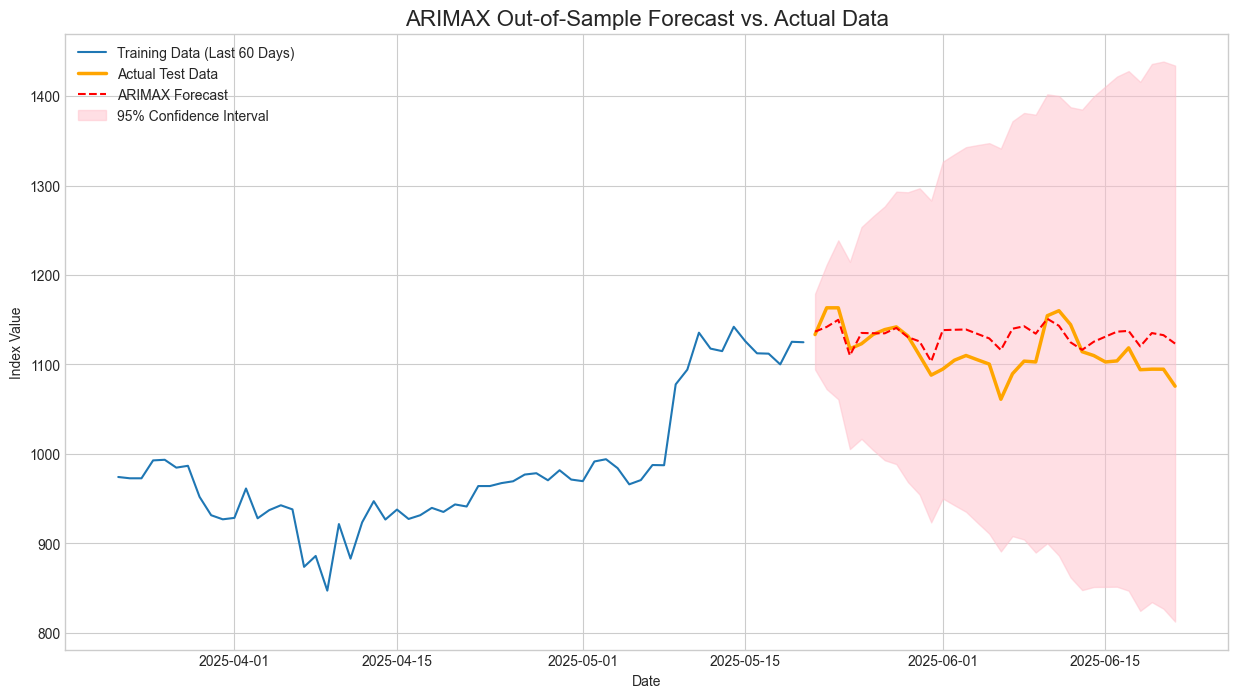


--- Out-of-Sample Forecast Error Metrics ---
Mean Absolute Error (MAE):       22.70
Root Mean Squared Error (RMSE):    27.49
Mean Absolute Percentage Error (MAPE): 2.06%


In [18]:
# Cell 14: (New) Generate and Plot Out-of-Sample Forecast

print("--- Generating Out-of-Sample Forecast for the Test Period ---")

# Use the model trained on historical data to forecast over the test period.
# We MUST provide the exogenous variables for the forecast period (X_test).
forecast = arimax_fitted_train.get_forecast(steps=n_test, exog=X_test)

# Get forecast values and the confidence interval
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- Create the Comparison Plot ---
plt.figure(figsize=(15, 8))

# Plot recent historical training data for context
plt.plot(y_train.tail(60), label='Training Data (Last 60 Days)')

# Plot the actual, held-out test data that the model has never seen
plt.plot(y_test, label='Actual Test Data', color='orange', linewidth=2.5)

# Plot the model's forecast for the same test period
plt.plot(forecast_mean, label='ARIMAX Forecast', color='red', linestyle='--')

# Plot the confidence interval around the forecast
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='95% Confidence Interval')

plt.title('ARIMAX Out-of-Sample Forecast vs. Actual Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.show()

# --- Calculate Quantitative Error Metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
mape = np.mean(np.abs((y_test - forecast_mean) / y_test)) * 100

print(f"\n--- Out-of-Sample Forecast Error Metrics ---")
print(f"Mean Absolute Error (MAE):       {mae:.2f}")
print(f"Root Mean Squared Error (RMSE):    {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")